# BERTopic-Driven Stock Market Predictions: Unraveling Sentiment Insights
## Reproduction de la méthodologie du papier scientifique

**Objectif** : Reproduire l'approche du papier qui utilise BERTopic pour extraire des topics 
des commentaires boursiers, analyser leur sentiment, et intégrer ces features dans des 
modèles de deep learning pour améliorer la prédiction des prix des actions.

**Dataset** : Tweets pour 27 actions avec données boursières associées
**Période** : À définir selon vos données
**Modèles testés** : LSTM, CNN, CNN-LSTM, GAN
**Sentiment** : BERT et VADER

***Import des librairies***

In [126]:
# Installation et imports de toutes les bibliothèques nécessaires
# Inclure : pandas, numpy, sklearn, tensorflow/keras, transformers, bertopic, 
# vader, matplotlib, seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import re
import string

from bertopic import BERTopic
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Attempt to import advanced models
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    USE_FINBERT = True
except ImportError:
    USE_FINBERT = False


# Ensure NLTK data is downloaded
nltk.download('vader_lexicon')


ModuleNotFoundError: No module named 'bertopic'

**SECTION 1 : Chargement et Exploration des Données**

***Chargement des données***

In [57]:
# Charger le dataset contenant les tweets pour les 27 actions
# Colonnes attendues : Date, Tweet, Stock Name, Company Name
# Vérifier la structure du dataset et afficher les premières lignes

#Charger les données de marché (prix, volume) pour les 27 actions
# Colonnes attendues : Date, Open, High, Low, Close, Adj Close, Volume, Stock Name
# Vérifier la correspondance des dates entre tweets et données boursières
# Paths 
tweets_path = 'data/stock_tweets.csv'
prices_path = 'data/stock_yfinance_data.csv'

# Charger tweets et price data
tweets_df = pd.read_csv(tweets_path)
prices_df = pd.read_csv(prices_path)

# basic info
print('Tweets shape:', tweets_df.shape)
print('Price shape:', prices_df.shape)

Tweets shape: (80793, 4)
Price shape: (6300, 8)


In [58]:
#Exploration des données de tweets. 

print("APERÇU DES DONNÉES de TWEETS")
print(tweets_df.head())
print("=" * 80)

print("INFORMATIONS SUR LES COLONNES")
print(tweets_df.info())
print("=" * 80)

print("VALEURS MANQUANTES")
print(tweets_df.isnull().sum())
print("=" * 80)
print("ACTIONS PRÉSENTES DANS LE DATASET")
unique_stocks = tweets_df['Stock Name'].unique()
print(f"Nombre d'actions uniques : {len(unique_stocks)}")
print(f"Liste des actions : {sorted(unique_stocks)}")

#Conversion de la colonne Date en format datetime
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])

# Extraire uniquement la date (sans l'heure) pour les agrégations quotidiennes
tweets_df['Date_only'] = tweets_df['Date'].dt.date
print("=" * 80)
print("PÉRIODE COUVERTE PAR LES DONNÉES")
print(f"Date de début : {tweets_df['Date'].min()}")
print(f"Date de fin   : {tweets_df['Date'].max()}")


APERÇU DES DONNÉES de TWEETS
                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  
INFORMATIONS SUR LES COLONNES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  objec

In [59]:
#Exploration des données boursières. 

print("APERÇU DES DONNÉES BOURSIERES")
print(prices_df.head())
print("=" * 80)

print("INFORMATIONS SUR LES COLONNES")
print(prices_df.info())
print("=" * 80)

print("VALEURS MANQUANTES")
print(prices_df.isnull().sum())
print("=" * 80)
print("ACTIONS PRÉSENTES DANS LE DATASET")
unique_stocks = prices_df['Stock Name'].unique()
print(f"Nombre d'actions uniques : {len(unique_stocks)}")
print(f"Liste des actions : {sorted(unique_stocks)}")

#Conversion de la colonne Date en format datetime
prices_df['Date'] = pd.to_datetime(prices_df['Date'])

# Extraire uniquement la date (sans l'heure) pour les agrégations quotidiennes
prices_df['Date_only'] = prices_df['Date'].dt.date
print("=" * 80)
print("PÉRIODE COUVERTE PAR LES DONNÉES")
print(f"Date de début : {prices_df['Date'].min()}")
print(f"Date de fin   : {prices_df['Date'].max()}")


APERÇU DES DONNÉES BOURSIERES
         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  
0  53868000       TSLA  
1  51094200       TSLA  
2  91449900       TSLA  
3  55297800       TSLA  
4  43898400       TSLA  
INFORMATIONS SUR LES COLONNES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        6300 non-null   object 
 1   Open        6300 non-null   float64
 2   High        6300 non-null   float64
 3   Low        

***Analyse exploratoire des tweets***

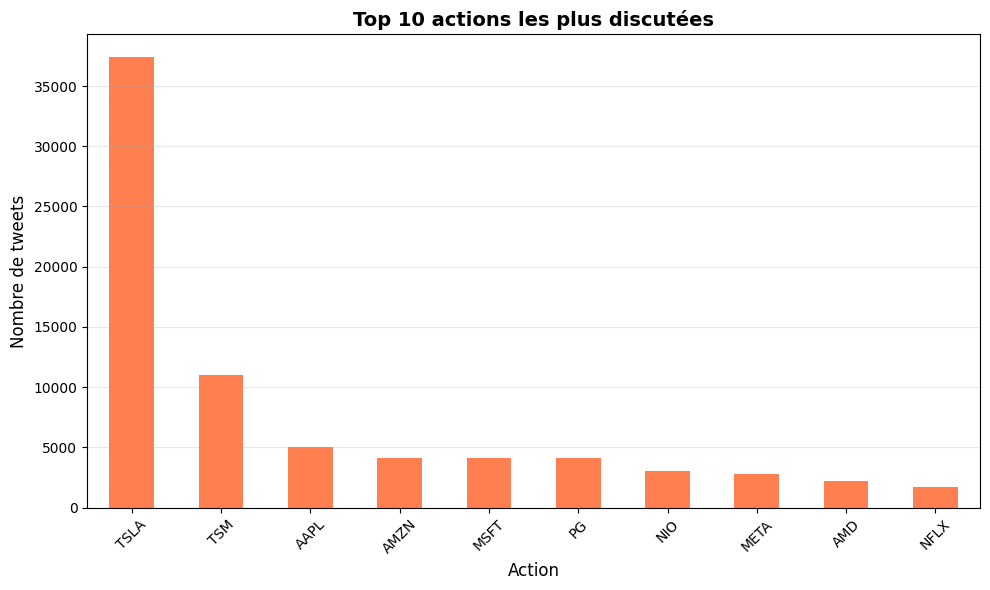

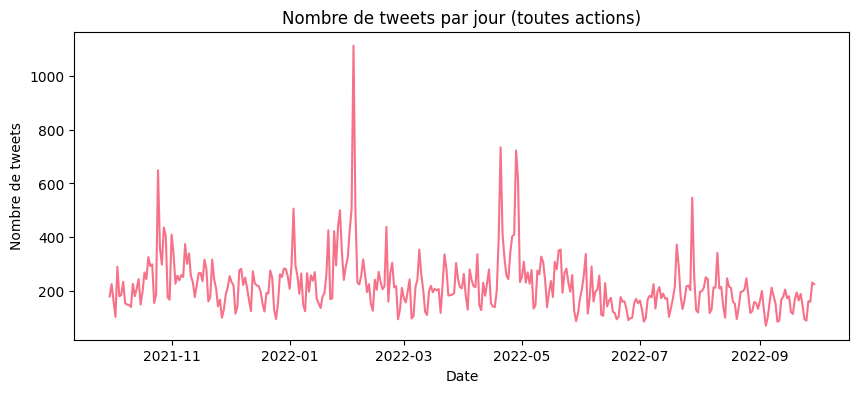

Longueur moyenne des tweets: 27.38 mots


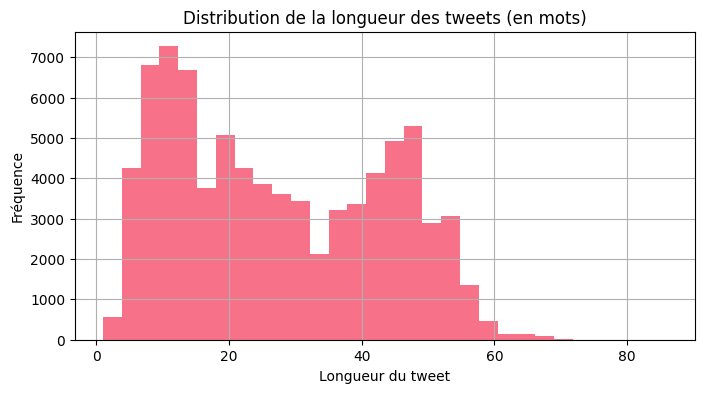

In [60]:
#Statistiques descriptives sur les tweets
# - Nombre de tweets par action
# - Distribution temporelle des tweets
# - Longueur moyenne des tweets
# - Visualisations (histogrammes, time series)


# Statistiques descriptives sur les tweets

# Nombre de tweets par action
tweets_per_stock = (
    tweets_df['Stock Name']
    .value_counts()
    .sort_values(ascending=False)
)

# Graphique : Top 10 actions
plt.figure(figsize=(10, 6))
tweets_per_stock.head(10).plot(kind='bar', color='coral')

plt.xlabel('Action', fontsize=12)
plt.ylabel('Nombre de tweets', fontsize=12)
plt.title('Top 10 actions les plus discutées', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution temporelle des tweets
distribution_temporelle = tweets_df.groupby('Date_only')['Tweet'].count()

plt.figure(figsize=(10,4))
distribution_temporelle.plot(kind='line')
plt.title("Nombre de tweets par jour (toutes actions)")
plt.xlabel("Date")
plt.ylabel("Nombre de tweets")
plt.show()

# Longueur moyenne des tweets (en mots)
tweets_df['longueur'] = tweets_df['Tweet'].astype(str).apply(lambda x: len(x.split()))
longueur_moyenne_globale = tweets_df['longueur'].mean()
print(f"Longueur moyenne des tweets: {longueur_moyenne_globale:.2f} mots")

# Histogramme de la longueur des tweets
plt.figure(figsize=(8,4))
tweets_df['longueur'].hist(bins=30)
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Longueur du tweet")
plt.ylabel("Fréquence")
plt.show()

***Analyse exploratoire des données boursières***

In [61]:
#Statistiques descriptives sur les prix
# - Évolution des prix (Close) pour quelques actions
# - Distribution des volumes
# - Volatilité par action

Actions sélectionnées pour visualisation : ['TSLA', 'TSM', 'AAPL', 'AMZN', 'MSFT']


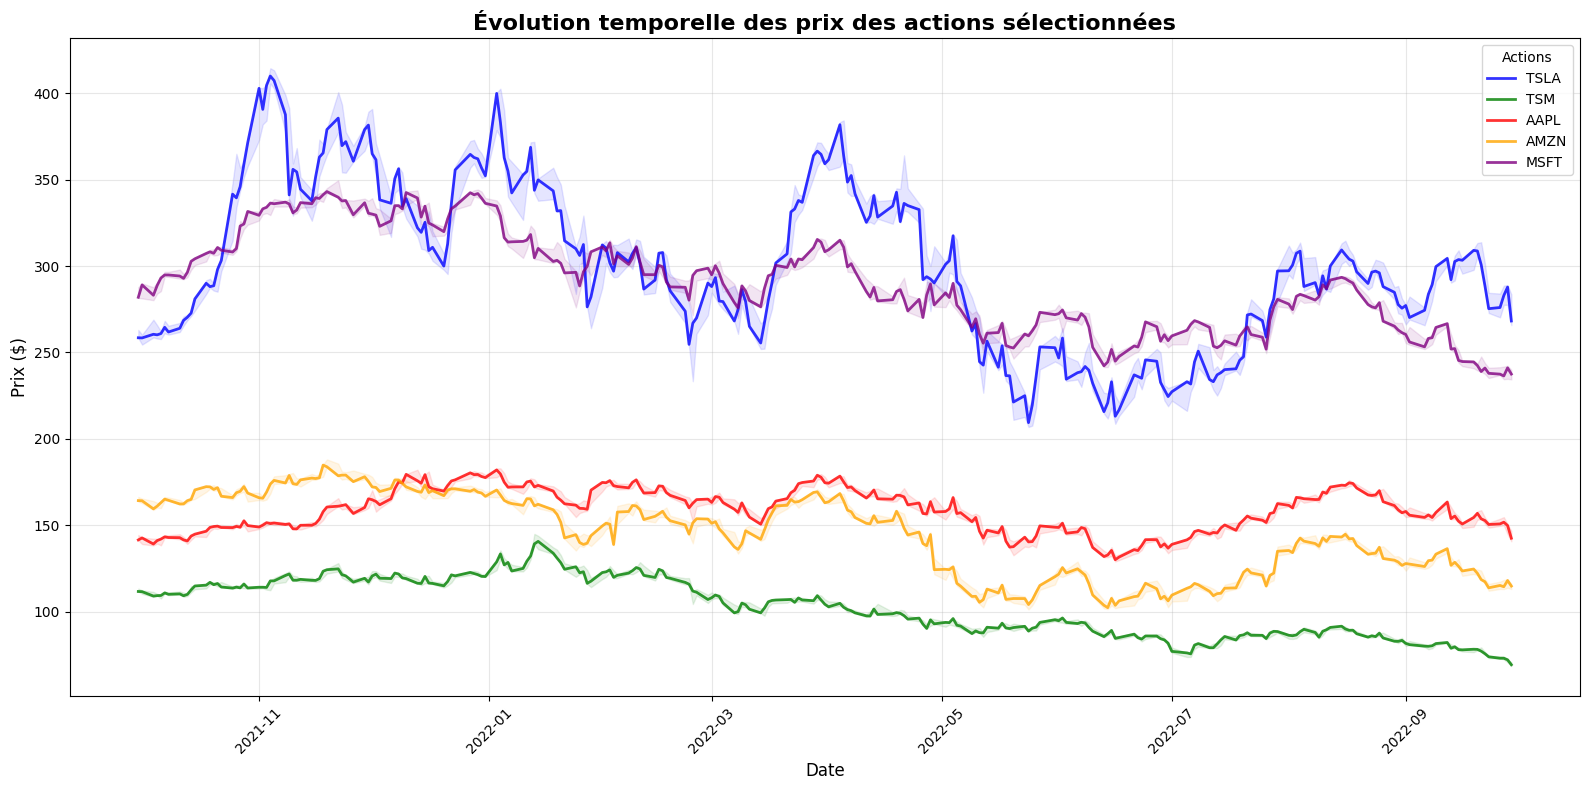

In [62]:
#EVOLUTION DES PRIX (Close) POUR QUELQUES ACTIONS

# Les 5 actions les plus discutées (basé sur les tweets)
if 'Stock Name' in tweets_df.columns:
    top_stocks = tweets_df['Stock Name'].value_counts().head(5).index.tolist()
else:
    top_stocks = prices_df['Stock Name'].unique()[:5]

print(f"Actions sélectionnées pour visualisation : {top_stocks}")

# Palette de couleurs pour chaque action
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']

plt.figure(figsize=(16, 8))

for idx, stock in enumerate(top_stocks):
    stock_data = prices_df[prices_df['Stock Name'] == stock].sort_values('Date')
    
    # Tracer la ligne du prix de clôture
    plt.plot(stock_data['Date'], stock_data['Close'], 
             linewidth=2, color=colors[idx], alpha=0.8, label=stock)
    
    # Remplir la zone High-Low
    plt.fill_between(stock_data['Date'], stock_data['Low'], stock_data['High'], 
                     color=colors[idx], alpha=0.1)

plt.title("Évolution temporelle des prix des actions sélectionnées", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="Actions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

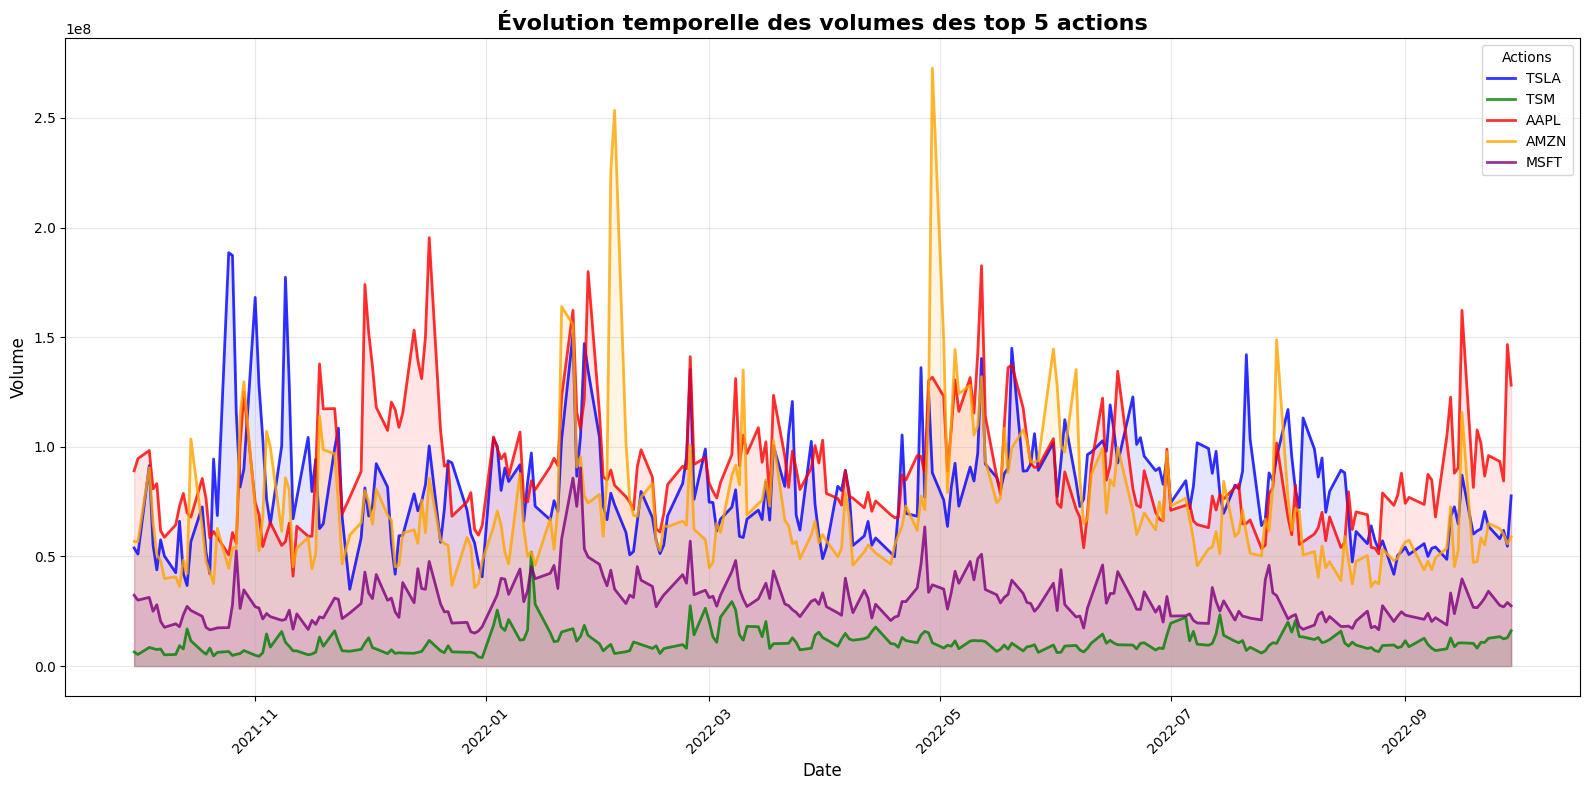

In [63]:
plt.figure(figsize=(16, 8))

for idx, stock in enumerate(top_stocks):
    stock_data = prices_df[prices_df['Stock Name'] == stock].sort_values('Date')
    
    # Tracer la ligne du volume
    plt.plot(stock_data['Date'], stock_data['Volume'], 
             linewidth=2, color=colors[idx], alpha=0.8, label=stock)
    
    # Optionnel : zone semi-transparente pour visualiser les fluctuations
    plt.fill_between(stock_data['Date'], 0, stock_data['Volume'], 
                     color=colors[idx], alpha=0.1)

plt.title("Évolution temporelle des volumes des top 5 actions", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volume", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="Actions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

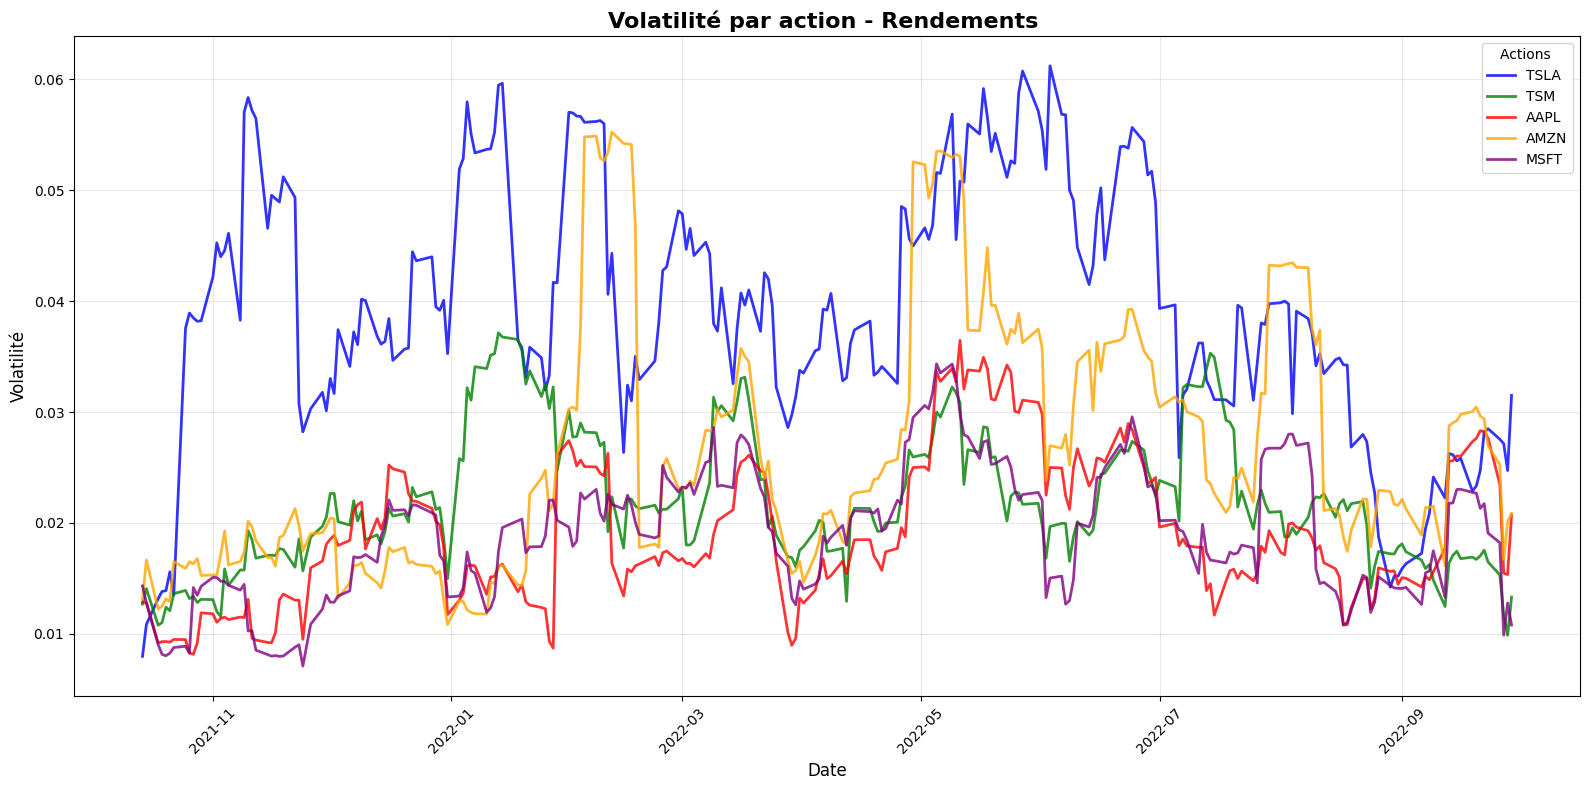

In [64]:
plt.figure(figsize=(16, 8))
for idx, stock in enumerate(top_stocks):
    stock_data = prices_df[prices_df['Stock Name'] == stock].sort_values('Date')
    
    # Volatilité quotidienne (rendements)
    returns = stock_data['Close'].pct_change()
    rolling_vol = returns.rolling(window=10).std()  # volatilité glissante sur 10 jours pour lisibilité
    plt.plot(stock_data['Date'], rolling_vol, 
             linewidth=2, color=colors[idx], alpha=0.8, label=f"{stock}")
    

plt.title("Volatilité par action - Rendements ", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volatilité", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="Actions ", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

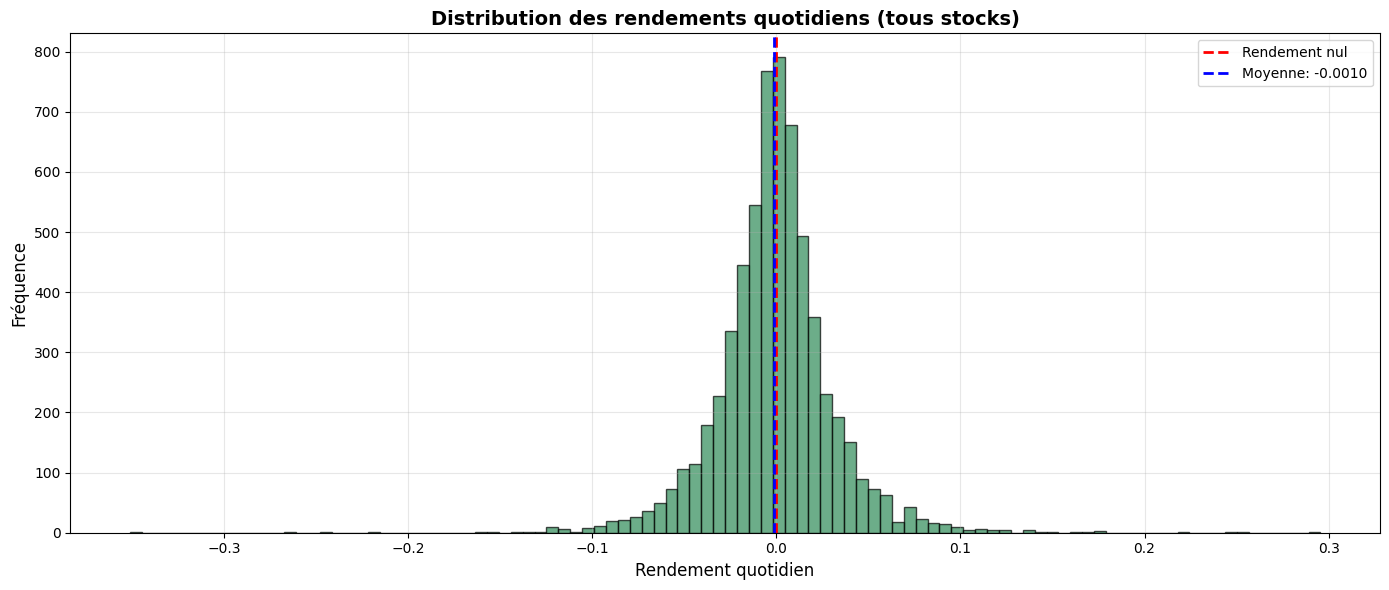

In [65]:
# RENDEMENTS QUOTIDIENS

# Calculer les rendements pour toutes les actions
prices_df = prices_df.sort_values(['Stock Name', 'Date'])
prices_df['Daily_Return'] = prices_df.groupby('Stock Name')['Close'].pct_change()

# Visualisation
plt.figure(figsize=(14, 6))
plt.hist(prices_df['Daily_Return'].dropna(), bins=100, color='seagreen', 
         edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Rendement nul')
plt.axvline(prices_df['Daily_Return'].mean(), color='blue', linestyle='--', 
            linewidth=2, label=f"Moyenne: {prices_df['Daily_Return'].mean():.4f}")
plt.xlabel('Rendement quotidien', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.title('Distribution des rendements quotidiens (tous stocks)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**SECTION 2 : Prétraitement des Tweets**

***Nettoyage des tweets***

In [66]:
# Prétraitement du texte des tweets
# - Suppression des URLs, mentions (@), hashtags si nécessaire
# - Suppression des caractères spéciaux
# - Conversion en minuscules (optionnel selon la méthode)
# - Gestion des emojis (VADER les utilise, donc les conserver)
# Note : Le papier utilise VADER qui gère bien les emojis et la ponctuation

In [67]:
# Fonction de prétraitement
def preprocess_tweet(text):
    """
    Prétraite un tweet en conservant les emojis et la ponctuation pour VADER
    
    Args:
        text: le texte du tweet
    
    Returns:
        text nettoyé
    """
    text = str(text)
    
    # 0. Décoder les entités HTML (amp, gt, lt, etc.)
    import html
    text = html.unescape(text)
    
    # 1. Supprimer les URLs (http, https, www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 2. Supprimer les mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # 3. Gérer les cashtags et montants différemment
    # a) Remplacer les tickers $AAPL par TICKER_AAPL (pour les identifier)
    text = re.sub(r'\$([A-Z]{1,5})(?!\d)', r'TICKER_\1', text)
    
    # b) Remplacer les montants $123.45 par AMOUNT_123.45 (pour les préserver)
    text = re.sub(r'\$(\d+(?:\.\d+)?[BMK]?)', r'AMOUNT_\1', text)
    
    # 4. Remplacer les hashtags par le texte sans #
    # Ex: #bullish -> bullish
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # 5. Gérer les pourcentages (les garder)
    text = re.sub(r'(\d+(?:\.\d+)?)\s*%', r'\1percent', text)
    
    # 6. Remplacer les slashes par des espaces (sauf dans les dates)
    text = re.sub(r'(\d+)/(\d+)/(\d+)', r'\1-\2-\3', text)  # dates
    text = re.sub(r'/', ' ', text)  # autres slashes
    
    # 7. Supprimer les caractères spéciaux SAUF ponctuation et emojis
    # On garde : lettres, chiffres, espaces, ponctuation (!?.,;:), apostrophes, tirets, underscores
    text = re.sub(r'[^\w\s!?.,;:\'\"-]', ' ', text, flags=re.UNICODE)
    
    # 8. Supprimer les nombres isolés de 1-2 chiffres en début de tweet (numérotation)
    text = re.sub(r'^\d{1,2}\s+', '', text)
    
    # 9. Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text)
    
    # 10. Retirer les espaces en début et fin
    text = text.strip()
    
    # Note: On NE convertit PAS en minuscules car :
    # - VADER utilise les majuscules pour détecter l'intensité ("GOOD" vs "good")
    # - BERT gère bien la casse
    
    return text

In [68]:
#Appliquer le prétraitement à tous les tweets
tweets_df['Tweet_original'] = tweets_df['Tweet']  # Sauvegarder l'original
tweets_df['Tweet_clean'] = tweets_df['Tweet'].apply(preprocess_tweet)

# Vérifier les tweets vides après nettoyage
empty_tweets = tweets_df[tweets_df['Tweet_clean'].str.strip() == '']
print(f"Nombre de tweets vides après nettoyage : {len(empty_tweets)}")

Nombre de tweets vides après nettoyage : 0


In [69]:
comparison_df = tweets_df[['Tweet_original', 'Tweet_clean']].head(15)
for idx, row in comparison_df.iterrows():
    print(f"\n--- Tweet {idx} ---")
    print(f"AVANT : {row['Tweet_original'][:150]}...")
    print(f"APRÈS : {row['Tweet_clean'][:150]}...")
    print("-" * 80)



--- Tweet 0 ---
AVANT : Mainstream media has done an amazing job at brainwashing people. Today at work, we were asked what companies we believe in &amp; I said @Tesla because...
APRÈS : Mainstream media has done an amazing job at brainwashing people. Today at work, we were asked what companies we believe in I said because they make th...
--------------------------------------------------------------------------------

--- Tweet 1 ---
AVANT : Tesla delivery estimates are at around 364k from the analysts. $tsla...
APRÈS : Tesla delivery estimates are at around 364k from the analysts. tsla...
--------------------------------------------------------------------------------

--- Tweet 2 ---
AVANT : 3/ Even if I include 63.0M unvested RSUs as of 6/30, additional equity needed for the RSUs is 63.0M x $54.20 = $3.4B. If the deal closed tomorrow at $...
APRÈS : Even if I include 63.0M unvested RSUs as of 6 30, additional equity needed for the RSUs is 63.0M x AMOUNT_54.20 AMOUNT_3.4B. If the de

***Filtrage par action***

In [70]:
# Organiser les tweets par action (Stock Name)
# Créer une structure permettant de traiter chaque action séparément
# Exemple : dictionnaire {stock_name: list_of_tweets}

In [ ]:
# 1. Créer un dictionnaire {stock_name: list_of_tweets}
tweets_by_stock = {}

for stock in tweets_df['Stock Name'].unique():
    stock_tweets = tweets_df[tweets_df['Stock Name'] == stock]['Tweet_clean'].tolist()
    tweets_by_stock[stock] = stock_tweets


# Créer un DataFrame récapitulatif
stats_by_stock = []
for stock, tweets in tweets_by_stock.items():
    stats_by_stock.append({
        'Stock Name': stock,
        'Nombre de tweets': len(tweets),
        'Longueur moyenne (caractères)': np.mean([len(t) for t in tweets]),
        'Longueur moyenne (mots)': np.mean([len(t.split()) for t in tweets])
    })
    
stats_df = pd.DataFrame(stats_by_stock).sort_values('Nombre de tweets', ascending=False)
print(stats_df.to_string(index=False))

Stock Name  Nombre de tweets  Longueur moyenne (caractères)  Longueur moyenne (mots)
      TSLA             37422                     150.772807                25.595692
       TSM             11034                      87.041599                16.474171
      AAPL              5056                     188.690071                28.803995
      AMZN              4089                     201.699438                30.738078
      MSFT              4089                     201.699438                30.738078
        PG              4089                     201.699438                30.738078
       NIO              3021                     143.009930                23.352863
      META              2751                     189.992730                29.199200
       AMD              2227                     203.647957                30.874270
      NFLX              1727                     184.615518                27.433700
      GOOG              1291                     194.151046      

In [72]:
#A FAIRE : Vérifier les tweets Amazn, msft et PG. Ce sont les mêmes ??? 

In [73]:
def get_tweets_for_stock(stock_name):
    """
    Récupère les tweets d'une action spécifique
    
    Args:
        stock_name: nom de l'action (ex: 'TSLA', 'AAPL')
    
    Returns:
        list de tweets nettoyés
    """
    if stock_name in tweets_by_stock:
        return tweets_by_stock[stock_name]
    else:
        print(f" Action '{stock_name}' non trouvée")
        return []


In [74]:
# Choisir une action spécifique
TARGET_TICKER = 'AMZN'


stock_tweets = get_tweets_for_stock(TARGET_TICKER)
print(f"Action testée : {stock_tweets}")
print(f"Nombre de tweets récupérés : {len(stock_tweets)}")
print(f"Premier tweet : {stock_tweets[0][:100]}...")

Action testée : ["A group of lawmakers led by Sen. Elizabeth Warren D-Mass. is asking the Federal Trade Commission to reject Amazon's, TICKER_AMZN, proposed acquisition of iRobot, per a letter shared first with Axios.", "TICKER_NIO just because I'm down money doesn't mean this is a bad investment. The whole market, everything sucks right now. 2-5 years from now, I'm confident it will pay off. Long the best TICKER_AAPL TICKER_AMZN TICKER_TSLA TICKER_GOOGL TICKER_NIO", 'Today s drop in TICKER_SPX is a perfect example of what happens when TICKER_AAPL and TICKER_AMZN turn lower. There are a few names that have held up markets for years. Those names are finally dropping and we are beginning to see the damage. No healthy market is driven by just a few names.', 'Druckenmiller owned TICKER_CVNA this year Munger bought TICKER_BABA on margin Aswath Dean of Valuation Damodoran loved TICKER_AMZN and TICKER_META all year No one is safe from investing losses but be wary of anyone always on the right

**SECTION 3: Extraction des Topics avec BERTopic**

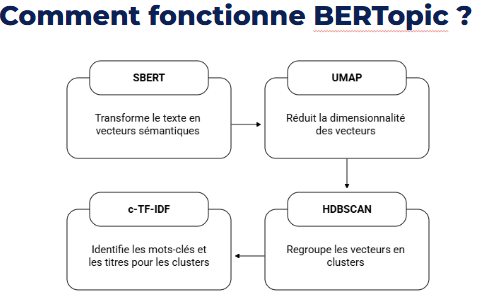

***Initialisation et entrainement du modèle BERTopic***

In [75]:
# Créer et entraîner le modèle BERTopic en une seule étape
# BERTopic fait automatiquement :
# 1. Embeddings avec Sentence-BERT (par défaut : 'all-MiniLM-L6-v2')
# 2. Réduction de dimension avec UMAP
# 3. Clustering avec HDBSCAN
# 4. Génération des topics avec c-TF-IDF

# Paramètres optionnels (si tu veux personnaliser) :
# - language="multilingual" si tweets multilingues
# - min_topic_size=10 (taille minimale d'un cluster)
# - nr_topics="auto" ou un nombre spécifique pour réduire les topics

# topic_model = BERTopic(language="english", 
#                        min_topic_size=10,
#                        verbose=True)

# # Entraîner le modèle sur les tweets
# # docs = liste de tous les tweets (strings)
# topics, probabilities = topic_model.fit_transform(docs)

# topics : array contenant le topic_id pour chaque tweet
# probabilities : probabilité d'appartenance au topic assigné

In [130]:
# Préparer les documents (liste des tweets pour AMZN)
docs = stock_tweets

print(f"\nNombre de tweets à analyser : {len(docs)}")
print(f"Exemples de tweets :")
for i, tweet in enumerate(docs[:3], 1):
    print(f"  {i}. {tweet[:100]}...")

# Initialiser et entraîner BERTopic
print("\n" + "=" * 80)
print("ENTRAÎNEMENT DU MODÈLE BERTOPIC...")
print("=" * 80)

# Paramètres du modèle
topic_model = BERTopic(
    language="english",           # Langue des tweets
    min_topic_size=10,            # Taille minimale d'un cluster (ajustable selon le nombre de tweets)
    nr_topics="auto",             # Nombre de topics automatique
    verbose=True,                 # Afficher les étapes
    calculate_probabilities=True  # Calculer les probabilités d'appartenance
)

# Entraîner le modèle
print("\n⏳ Entraînement en cours...\n")
topics, probabilities = topic_model.fit_transform(docs)


2026-02-06 11:53:26,794 - BERTopic - Embedding - Transforming documents to embeddings.



Nombre de tweets à analyser : 4089
Exemples de tweets :
  1. A group of lawmakers led by Sen. Elizabeth Warren D-Mass. is asking the Federal Trade Commission to ...
  2. TICKER_NIO just because I'm down money doesn't mean this is a bad investment. The whole market, ever...
  3. Today s drop in TICKER_SPX is a perfect example of what happens when TICKER_AAPL and TICKER_AMZN tur...

ENTRAÎNEMENT DU MODÈLE BERTOPIC...

⏳ Entraînement en cours...



Batches: 100%|██████████| 128/128 [02:18<00:00,  1.08s/it]
2026-02-06 11:56:15,441 - BERTopic - Embedding - Completed ✓
2026-02-06 11:56:15,442 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-06 11:56:56,444 - BERTopic - Dimensionality - Completed ✓
2026-02-06 11:56:56,448 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-06 11:56:58,174 - BERTopic - Cluster - Completed ✓
2026-02-06 11:56:58,175 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026-02-06 11:56:58,454 - BERTopic - Representation - Completed ✓
2026-02-06 11:56:58,455 - BERTopic - Topic reduction - Reducing number of topics
2026-02-06 11:56:58,493 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-06 11:56:58,710 - BERTopic - Representation - Completed ✓
2026-02-06 11:56:58,712 - BERTopic - Topic reduction - Reduced number of topics from 82 to 15


***Analyse et visualisation des topics***

In [76]:
#Explorer les topics découverts
# - Afficher les mots-clés pour chaque topic
# - Visualiser la distribution des topics (nombre de tweets par topic)
# - Créer une visualisation 2D des topics (UMAP)
# - Interpréter les thèmes : sont-ils cohérents avec le domaine boursier ?


# Analyser les topics identifiés par BERTopic

# # Obtenir les informations sur tous les topics
# topic_info = topic_model.get_topic_info()
# print(topic_info)
# # Colonnes : Topic (id), Count (nombre de docs), Name (mots-clés du topic)

# # Voir les mots-clés d'un topic spécifique (ex: topic 0)
# print(topic_model.get_topic(0))
# # Retourne : [(mot1, score), (mot2, score), ...]

# # Nombre total de topics (hors outliers qui ont topic_id = -1)
# n_topics = len(topic_info) - 1  # -1 car topic -1 = outliers
# print(f"Nombre de topics identifiés : {n_topics}")



# # Commentaire : Visualiser les topics pour validation qualitative

# # 1. Visualisation interactive des topics dans l'espace 2D
# fig1 = topic_model.visualize_topics()
# fig1.show()

# # 2. Barchart des mots-clés pour chaque topic
# fig2 = topic_model.visualize_barchart(top_n_topics=10)
# fig2.show()

# # 3. Heatmap de similarité entre topics
# fig3 = topic_model.visualize_heatmap()
# fig3.show()

# # 4. Hierarchie des topics
# fig4 = topic_model.visualize_hierarchy()
# fig4.show()

In [77]:
# # Ajouter les topics au dataframe des tweets

# # Ajouter la colonne topic_id
# df_tweets['topic_id'] = topics
# df_tweets['topic_probability'] = probabilities

# # Ajouter les mots-clés du topic (optionnel, pour interprétation)
# def get_topic_keywords(topic_id):
#     if topic_id == -1:
#         return "Outlier"
#     return ", ".join([word for word, _ in topic_model.get_topic(topic_id)[:5]])

# df_tweets['topic_keywords'] = df_tweets['topic_id'].apply(get_topic_keywords)

# # Vérifier la distribution des topics
# print(df_tweets['topic_id'].value_counts())

# # Sauvegarder le modèle BERTopic (pour réutilisation)
# topic_model.save("bertopic_model")

# Pour charger plus tard : topic_model = BERTopic.load("bertopic_model")

**SECTION 4: Analyse de sentiment**

***Sentiment avec VADER (sur les tweets bruts)***

In [78]:
# Appliquer VADER pour obtenir le sentiment de chaque tweet
# - VADER est adapté aux textes courts et aux réseaux sociaux
# - Il gère : négations, intensificateurs, ponctuation, emojis, majuscules
# - Sortie : compound score entre -1 (très négatif) et +1 (très positif)
# - Catégoriser : Positive, Neutral, Negative selon des seuils

***Agrégation du sentiment VADER par jour et par action***

In [79]:
#Calculer le score de sentiment moyen quotidien par action
# - Grouper les tweets par (Date, Stock Name)
# - Calculer la moyenne pondérée des scores de sentiment
# - Créer une colonne 'score' dans le dataset boursier
# - Cette colonne représente le sentiment global quotidien

***Sentiment avec BERT (sur les tweets bruts)***

In [80]:
#Utiliser un modèle BERT fine-tuné pour l'analyse de sentiment
# - Modèle recommandé : 'nlptown/bert-base-multilingual-uncased-sentiment'
#   ou 'ProsusAI/finbert' (spécialisé finance)
# - Obtenir un score de sentiment pour chaque tweet
# - Normaliser les scores entre -1 et +1

***Agrégation du sentiment BERT par jour et par action***

In [81]:
#Calculer le score de sentiment BERT moyen quotidien par action
# - Même logique que pour VADER
# - Créer une colonne 'score_bert' dans le dataset boursier

**SECTION 5 : Sentiment des Topics**

***Attribution des topics aux tweets***

In [82]:
#Associer chaque tweet à son topic identifié par BERTopic
# - Ajouter une colonne 'topic_id' au dataframe des tweets
# - Gérer les outliers (topic = -1) : les exclure ou traiter séparément

***Calcul du sentiment des topics avec VADER***

In [83]:
# Pour chaque tweet, obtenir le sentiment du topic auquel il appartient
# - Méthode 1 : Sentiment moyen de tous les tweets d'un même topic
# - Méthode 2 : Sentiment de la représentation textuelle du topic (mots-clés)
# - Le papier semble utiliser la méthode 1
# - Créer une colonne 'topic_sentiment_vader'

***Calcul du sentiment des topics avec BERT***

In [84]:
#Même approche mais avec BERT
# - Calculer le sentiment moyen BERT pour chaque topic
# - Créer une colonne 'topic_sentiment_bert'

***Agrégation du sentiment des topics par jour et par action***

In [85]:
#Créer les colonnes 'score_topic_vader' et 'score_topic_bert'
# - Pour chaque (Date, Stock Name), calculer la moyenne des sentiments des topics
# - Ces colonnes seront des features supplémentaires dans les modèles

**SECTION 6 : Calcul des Indicateurs Techniques**

***Moyennes mobiles (MA7, MA20)***

In [86]:
# Calculer les moyennes mobiles sur 7 et 20 jours
# - MA7 : moyenne du Close sur les 7 derniers jours
# - MA20 : moyenne du Close sur les 20 derniers jours
# - Ces indicateurs capturent les tendances court et moyen terme

***MACD (Moving Average Convergence Divergence)***

In [87]:
#Calculer le MACD
# - EMA 12 jours et EMA 26 jours
# - MACD = EMA12 - EMA26
# - Indicateur de momentum qui montre la relation entre deux moyennes mobiles

***Bandes de Bollinger***

In [88]:
#Calculer les Bandes de Bollinger
# - 20SD : écart-type du Close sur 20 jours (volatilité)
# - upper_band = MA20 + (2 × 20SD)
# - lower_band = MA20 - (2 × 20SD)
# - Indicateurs de volatilité et de surachat/survente

***EMA et Log Momentum***

In [89]:
#Calculer l'EMA et le log momentum
# - EMA : moyenne mobile exponentielle (plus de poids sur les données récentes)
# - log_momentum = log(Close_t / Close_{t-n})
# - Momentum : différence entre prix actuel et prix il y a N jours

***Consolidation du dataset final***

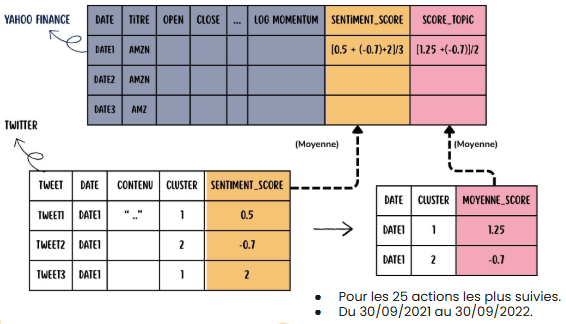

In [90]:
#Créer le dataset complet avec toutes les features
# - Fusionner données boursières + indicateurs techniques + scores de sentiment
# - Colonnes finales : Date, Open, High, Low, Close, Adj Close, Volume, 
#   MA7, MA20, MACD, 20SD, upper_band, lower_band, EMA, log_momentum,
#   score (VADER global), score_bert (BERT global),
#   score_topic_vader, score_topic_bert, Stock Name
# - Gérer les valeurs manquantes (NaN) dues aux fenêtres de calcul

**SECTION 7 : Préparatin des données pour le Machine Learning**

***Sélection d'une action pour les expériences***

In [91]:
#Pour reproduire le papier, sélectionner Amazon (AMZN)
# - Filtrer le dataset pour ne garder que AMZN
# - Le papier montre les résultats sur AMZN, on reproduira cela
# - Par la suite, on pourra itérer sur les 27 actions

***Split Train/Test***

In [92]:
#Diviser les données en ensemble d'entraînement et de test
# - Le papier utilise : train = toutes les données sauf les 20 derniers jours
# - Test = les 20 derniers jours
# - Respecter l'ordre chronologique (pas de shuffle)

***Normalisation avec MinMaxScaler***

In [93]:
#Normaliser les features numériques
# - Appliquer MinMaxScaler sur Adj Close séparément (comme dans le papier)
# - Puis appliquer MinMaxScaler sur l'ensemble du dataset
# - Sauvegarder les scalers pour l'inversion lors de l'évaluation
# - La normalisation améliore la convergence des réseaux de neurones

***Préparation des séquences pour LSTM***

In [94]:
#Créer des séquences temporelles pour LSTM
# - Fenêtre temporelle (time steps) : à définir (ex: 60 jours), [PAS DIT DANS LE PAPIER]
# - Pour chaque sample, prendre les N derniers jours comme input
# - La target est le Adj Close du jour suivant
# - Format : (n_samples, time_steps, n_features)

**SECTION 8 : BASELINE (sans sentiment)**


_______________FAIRE UN COURT TEXTE POUR EXPLIQUER L'ABADON DU MODELE GAN__________

***LSTM - Baseline***

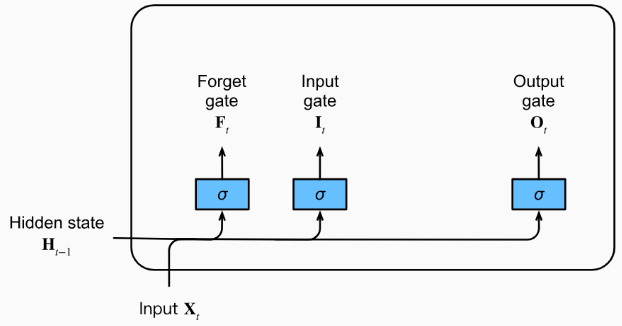

In [95]:
#Construire et entraîner un modèle LSTM sans features de sentiment
# - Architecture : LSTM(50 units, relu) + Dense(1)
# - Input features : Open, High, Low, Close, Volume, MA7, MA20, MACD, etc.
#   (SANS score, score_topic)
# - Optimizer : Adam
# - Loss : MSE
# - Epochs : 200
# - Entraîner sur le train set

***Évaluation LSTM Baseline***

In [96]:
#Évaluer les performances du LSTM Baseline
# - Prédictions sur train et test sets
# - Calculer : RMSE, MAE, R², MAPE
# - Visualiser : courbes de prédiction vs réalité (train et test)
# - Visualiser : courbe de loss pendant l'entraînement

***CNN - Baseline***
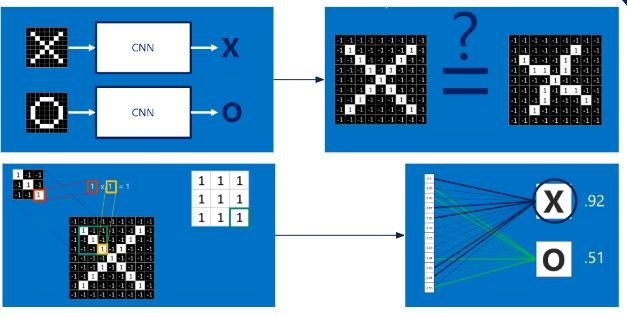

In [97]:
# Construire et entraîner un modèle CNN sans features de sentiment
# - Architecture : Conv1D(64 filters, kernel=2, relu) + MaxPooling1D(2) 
#   + Flatten + Dense(50, relu) + Dense(1)
# - Mêmes features d'input que LSTM Baseline
# - Optimizer : Adam, Loss : MSE, Epochs : 200

***Évaluation CNN Baseline***

In [98]:
# Évaluer CNN Baseline (mêmes métriques que LSTM)

***CNN-LSTM - Baseline***

In [99]:
#Construire un modèle hybride CNN-LSTM sans sentiment
# - Architecture : Conv1D(64, 2, relu) + LSTM(50, relu) + Dense(1)
# - Le CNN extrait des features spatiales, le LSTM capture les dépendances temporelles
# - Mêmes paramètres d'entraînement

***Évaluation CNN-LSTM Baseline***

In [100]:
# Évaluer CNN-LSTM Baseline

**SECTION 9 :Expériences - Avec Sentiment GLOBAL (sans topics)**

***LSTM + Sentiment VADER (sans topics)***

In [101]:
#LSTM avec ajout du score de sentiment VADER global
# - Input features : features Baseline + score (VADER)
# - Même architecture que Baseline

***LSTM + Sentiment BERT (sans topics)***

In [102]:
#LSTM avec ajout du score de sentiment BERT global
# - Input features : features Baseline + score_bert

***Répéter pour CNN, CNN-LSTM***

In [103]:
####

***Évaluation par rapport à la baseline***

In [104]:
#Évaluer et comparer avec Baseline pour chaque modèle

**SECTION 10: Expériences - Avec Sentiment des TOPICS**

***LSTM + Sentiment VADER des Topics***

In [105]:
#LSTM avec ajout du score de sentiment des topics (VADER)
# - Input features : features Baseline + score_topic_vader
# - Cette expérience teste l'hypothèse clé du papier :
#   le sentiment des topics améliore significativement les prédictions

***LSTM + Sentiment BERT des Topics***

In [106]:
#Pareil LSTM mais avec score_topic_bert

***Répéter pour CNN, CNN-LSTM***

In [107]:
###

***Évaluation par rapport à la baseline/sentiment global***

In [108]:
###
# LSTM :Le papier montre une amélioration ~10% des métriques quand on ajoute les topics
#Le papier montre que CNN-LSTM + topics donne les meilleures performances sur tout les méthodes

**SECTION 11: Comparaison Globale des Résultats**

***Tableau récapitulatif des performances***

In [109]:
#Créer un DataFrame consolidant toutes les métriques
# - Lignes : tous les modèles testés (Baseline, +sentiment, +topics)
# - Colonnes : RMSE, MAE, R², MAPE (train et test)
# - Reproduire les Tableaux III, IV, V, VI, VII du papier

***Visualisations comparatives***

In [110]:
#Créer des graphiques pour comparer les modèles
# - Bar plots pour RMSE, MAE, R², MAPE
# - Heatmap des performances
# - Highlight : amélioration apportée par le sentiment des topics

***Analyse statistique***

In [111]:
#Tester la significativité des améliorations
# - Tests statistiques (t-test) pour vérifier si l'amélioration est significative
# - Calculer les pourcentages d'amélioration

**SECTION 12 : Extension aux 27 Actions**

***Pipeline automatisé pour toutes les actions***

In [112]:
#Créer une fonction qui applique tout le pipeline à une action
# - Input : stock_name
# - Output : métriques de performance pour tous les modèles
# - Permet de reproduire les expériences sur les 27 actions

***Exécution sur les 27 actions***

In [113]:
# Boucler sur les 27 actions et collecter les résultats
# - Attention : cela peut prendre plusieurs heures
# - Sauvegarder les résultats intermédiaires

***Analyse multi-actions***

In [114]:
#Analyser les performances agrégées
# - Moyenne des métriques sur les 27 actions
# - Identifier les actions pour lesquelles le sentiment des topics est le plus impactant
# - Corréler avec la volatilité, le volume, etc.

**SECTION 13 : Analyse Qualitatives des Topics**

***Interprétation des topics***

In [115]:
#Analyser qualitativement les topics découverts
# - Quels sont les thèmes principaux discutés pour chaque action ?
# - Y a-t-il des topics communs à plusieurs actions ?
# - Exemples de tweets représentatifs pour chaque topic

***Évolution temporelle des topics***

In [116]:
#Visualiser comment les topics évoluent dans le temps
# - Time series du nombre de tweets par topic
# - Corrélation entre l'émergence d'un topic et les mouvements de prix

***Topics et sentiment**

In [117]:
#Analyser la polarité des topics
# - Quels topics sont systématiquement positifs/négatifs ?
# - Relation entre type de topic et impact sur le prix

**SECTION 14 : Limites et améliorations possibles**

***Discussion des limites***

In [118]:
# Identifier les limites de l'approche
# - Qualité et représentativité des tweets (biais d'échantillonnage)
# - Période d'étude limitée (1 an)
# - Topics non supervisés : pas de garantie de pertinence
# - VADER et BERT peuvent manquer des nuances (sarcasme, contexte financier)
# - Pas de prise en compte d'autres sources d'information (news, reports)

***Pistes d'amélioration***

In [119]:
# Commentaire : Proposer des extensions
# - Analyse en temps réel
# - Intégration de données multi-sources (Twitter + Reddit + news)
# - Fine-tuning de BERT sur le domaine financier  ---> FinTWitterBERT à tester?
# - Modèles d'attention (Transformers) pour capturer les dépendances
# - Prise en compte des émotions (peur, euphorie) au-delà du sentiment
# - Analyse de causalité (Granger) entre sentiment et prix

**SECTION 15 : Conclusion**

***Résumé des résultats***

In [120]:
# Commentaire : Synthèse des findings
# - Le sentiment des topics extrait par BERTopic améliore significativement la prédiction
# - CNN-LSTM + sentiment des topics : meilleure architecture
# - VADER et BERT donnent des résultats comparables
# - L'information implicite des discussions en ligne est exploitable

***Implications pratiques***

In [121]:
# pplications potentielles
# - Outils d'aide à la décision pour traders
# - Systèmes d'alerte basés sur le sentiment
# - Stratégies de trading algorithmique
# - Nécessité de combiner avec d'autres analyses (fondamentale, technique)

**SECTION 16 : Annexes (si besoin)**

***Fonctions utilitaires***

In [122]:
# Commentaire : Regrouper toutes les fonctions réutilisables
# - Fonctions de preprocessing
# - Fonctions de calcul d'indicateurs techniques
# - Fonctions de création de modèles
# - Fonctions d'évaluation

***Sauvegarde des modèles et résultats***

In [123]:
#Sauvegarder les modèles entraînés et les résultats
# - Pickle ou HDF5 pour les modèles Keras
# - CSV pour les tableaux de résultats
# - JSON pour les configurations